http://www.patentsview.org/api/patent.html

In [4]:
import requests

In [5]:
fields = ["patent_abstract", "patent_date", "patent_num_cited_by_us_patents", "patent_title", 'patent_number']
fields.extend( [ 'cpc_subgroup_title', 'cpc_subgroup_id' ])
fields.extend( [ 'cited_patent_number' ] )
fields.extend(["inventor_first_name","inventor_last_name"])
fields.extend(["citedby_patent_number"])

fields_str = '''[%s]''' % ', '.join( [ '''"%s"''' % f for f in fields ] )

url = "http://www.patentsview.org/api/patents/query"

def query_patent( patent_number):
    
    
    query = '''{"patent_number":"%s"}''' % patent_number
    
    r = requests.get(url, params={'q':query, 'f':fields_str})
    r_json = r.json()
    data = r_json['patents'][0]
    
    # post-process
    citedby_patents = [ d['citedby_patent_number'] for d in data['citedby_patents'] if d['citedby_patent_number'] ] 
    data['citedby_patents'] = citedby_patents

    cited_patents = [ d['cited_patent_number'] for d in data['cited_patents'] if  d['cited_patent_number'] ] 
    data['cited_patents'] = cited_patents
    
    return data

In [6]:
import pickle

In [7]:
# cache
DATA = {}

DATA = pickle.load( open('DATA.pickle','rb') )

def get_patent( patent_number ):
    if patent_number in DATA:
        patent = DATA[patent_number]
    else:
        patent = query_patent( patent_number )
        DATA[ patent_number ] = patent
        
    return patent

In [58]:
pickle.dump( DATA, open('DATA.pickle','wb') )

In [8]:
r = get_patent( "6220251" )

In [9]:
print( r )

{'cpcs': [{'cpc_subgroup_id': 'A45D29/04', 'cpc_subgroup_title': 'Manicuring or pedicuring implements-Nail files, e.g. manually operated'}, {'cpc_subgroup_id': 'A45D29/18', 'cpc_subgroup_title': 'Manicuring or pedicuring implements-Manicure or pedicure sets, e.g. combinations without case, etui, or the like'}, {'cpc_subgroup_id': 'A45D2029/026', 'cpc_subgroup_title': 'Manicuring or pedicuring implements-Nail clippers or cutters-for toenails, e.g. with a rod acting over the clipper'}], 'cited_patents': ['3955884', '4398800', '4640011', '4788768', '4809431', '4893406', '4930871', '4956915', '5046606', '5263754', '5357677', '5358297', '5370648', '5546658', '5775340', '5931167'], 'patent_title': 'Combination vision enhancement kit and nail clipper', 'patent_num_cited_by_us_patents': '23', 'citedby_patents': ['6381080', '6384990', '6523545', '6539632', '6553592', '6560874', '6683298', '6865812', '7131448', '7137356', '7263775', '7320180', '7464665', '7575335', '8096305', '8496013', 'D446352

# graph 

In [10]:
import graph_tool.all as gt

In [11]:
# create graph
g = gt.Graph()

# add vertex property
label_prop = g.new_vertex_property("string")
g.vp.patentnumber = label_prop 

label_prop = g.new_vertex_property("int")
g.vp.gen = label_prop 

In [12]:
generation = {}

In [13]:
nodes = {}
patents = {}
def add_node( patent, gen ):
    
    v = g.add_vertex()
    g.vp.patentnumber[ v ] = patent['patent_number']
    g.vp.gen[ v ] = gen
    nodes[patent['patent_number']] = v
    patents[ v ] = patent

### gen0

In [14]:
seed_number = "5123430"

seed_patent = get_patent( seed_number )

add_node( seed_patent, 0 )

## gen1

In [15]:
# cited
for citation_number in seed_patent['cited_patents']:
    patent = get_patent(citation_number)
    generation[citation_number] = 1
    
    add_node( patent, 1 )
    
# cited by
for citedby_number in seed_patent['citedby_patents']:
    patent = get_patent(citedby_number)
    generation[citedby_number] = 1
    
    add_node( patent, 1 )

In [16]:
# add edges

for v in g.vertices():
    
    patent_number = g.vp.patentnumber[v]
    
    patent = patents[ v ]
    
    target = v
    for cited_number in patent['cited_patents']:
        if cited_number in nodes:
            source = nodes[cited_number]
            
            e = g.add_edge(source, target)

In [17]:
pickle.dump( DATA, open('DATA.pickle','wb') )

In [18]:
g.save('gen_graph.graphml')

In [41]:
g.save('web/data/gen_graph.dot')

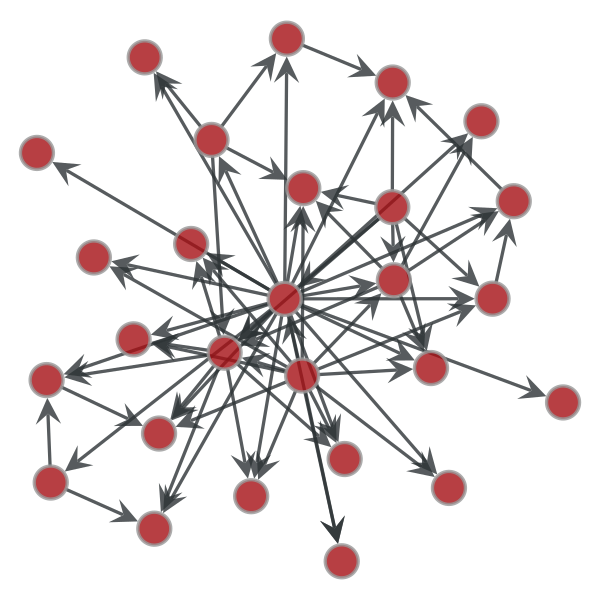

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f3f9d62eeb8, at 0x7f3f9d6455c0>

In [19]:
# draw
gt.graph_draw(g, output_size=(600, 600))#vertex_text=g.vertex_index, vertex_font_size=18,

In [39]:
gt.graphviz_draw(g,  size=(15, 15), layout='dot', output="graphviz-draw-local.svg", vsize=1.0, \
             gprops={'rankdir':'LR'}, penwidth=10, vprops={'shape':'box'})

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f475dc062b0, at 0x7f475dbbab70>

# Going to Graphviz

In [ ]:
filename = 'data/gen_graph.dot'

In [5]:
g.save(filename)

f = open(filename,"r")
graphdot = f.read()

NameError: name 'g' is not defined

In [35]:
import graphviz as gv

In [45]:
ggv = gv.Source(graphdot, filename=filename, format="png")

In [46]:
ggv.attr('graph', rankdir='LR')

AttributeError: 'Source' object has no attribute 'attr'

In [49]:
ggv.render()

'data/gen_graph.dot.png'

In [3]:
import pygraphviz as pgv

In [6]:
filename = 'data/gen_graph.dot'
G = pgv.AGraph( filename )  

In [8]:
G.size()

67

In [9]:
G.graph_attr['rankdir']='LR'

In [10]:
G.node_attr['shape']='box'

In [13]:
filename_web = 'web/data/gen_graph.dot'
G.write(filename_web)